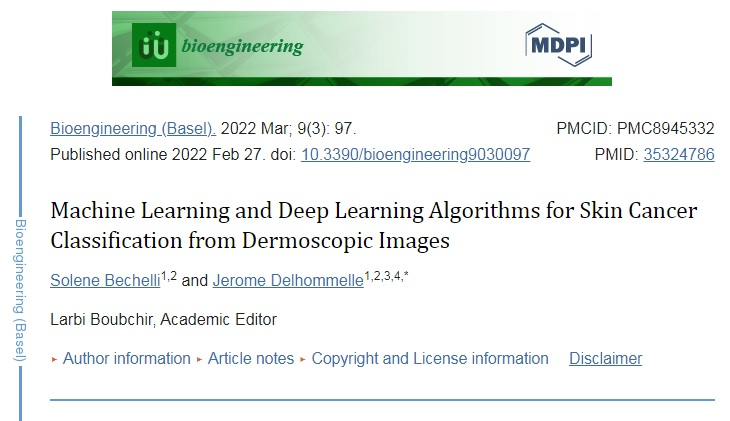

 **By: Samira Asadzadeh**

*   **Advisor:  Dr. Mr.Tabarzad**

*  **ISLAMIC AZAD UNIVERSITY SHIRAZ BRANCH Faculty of engineering**



In [ ]:
!pip install torch
!pip install torchvision
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Import Library

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import itertools
from sklearn.metrics import confusion_matrix
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import cross_val_score
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import scikitplot as skplt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from functools import partial
import random
from concurrent import futures
from sklearn.metrics.pairwise import euclidean_distances
import tensorflow as tf
from matplotlib import pyplot
from pylab import *
from keras.preprocessing.image import ImageDataGenerator
from numpy import save
from numpy import load
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from numpy import set_printoptions
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

#Connect Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

#!ls 'drive/My Drive'

Mounted at /content/drive


# Data

In [ ]:
trn_dir = '/content/drive/MyDrive/ProjectMl/dataset'
sz = 224
batch_size = 8
os.listdir(trn_dir)

['Benign', 'malignant']

In [ ]:
Benign_=glob.glob('/content/drive/MyDrive/ProjectMl/dataset/Benign/*.jpg')
Benign_ = len(Benign_)
malignant_=glob.glob('/content/drive/MyDrive/ProjectMl/dataset/malignant/*.jpg')
malignant_ =len(malignant_)

my_dict = {
    'Targets': ["Benign", "malignant"],
    'Count': [Benign_ , malignant_]
    
}

df = pd.DataFrame(my_dict, index=[0,1])
df.tail()

,Targets,Count
0,Benign,399
1,malignant,395


##Data Augmentation

In [ ]:
Benign_AUG = os.path.join('/content/drive/MyDrive/ProjectMl/dataset', 'Benign')
malignant_AUG = os.path.join('/content/drive/MyDrive/ProjectMl/dataset', 'malignant')


In [ ]:
datagen = ImageDataGenerator(
     rotation_range=50,
     vertical_flip=True,
     #brightness_range=[0.3,0.3],
     #zoom_range =([.7,.7])
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #horizontal_flip=True
)

total Data Augmentation malignant images: 1894


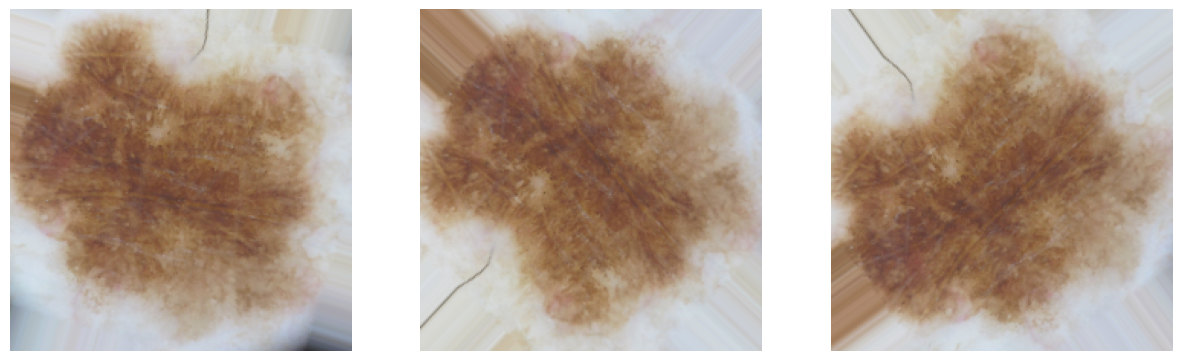

In [ ]:
# ImageDataGenerator rotation
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
fnames = [os.path.join(Benign_AUG, fname) for fname in os.listdir(Benign_AUG)]
for j in range(Benign_):
    img_path = fnames[j]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    x = tf.keras.preprocessing.image.img_to_array(img)
# Reshape it to (1, 224, 224, 3)
    x = x.reshape((1,) + x.shape) 
    #datagen = ImageDataGenerator(rotation_range=40, fill_mode='nearest')

# iterator
    aug_iter = datagen.flow(x, batch_size=1, save_to_dir = os.path.join('/content/drive/MyDrive/ProjectMl/dataset', 'aug'), save_format= 'jpg')

# generate samples and plot
    #fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
    for i in range(3):

	# convert to unsigned integers
      image = next(aug_iter)[0].astype('uint8')
 
	# plot image
      if j== 6 :
         
         ax[i].imshow(image)
         ax[i].axis('off')
Benign_AUG_ = os.path.join('/content/drive/MyDrive/ProjectMl/dataset', 'aug')
print('total Data Augmentation malignant images:', len(os.listdir(Benign_AUG_)))

# Data.Clases






In [ ]:
train_ds = datasets.ImageFolder(trn_dir)
train_ds.classes
train_ds.class_to_idx

{'Benign': 0, 'malignant': 1}

# Transformations






In [ ]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
len(train_ds)

794

##Create Training and Validation and Testing 

In [ ]:
train_D, test_set = train_test_split(train_ds, test_size=0.15, random_state=42)
train_set, val_set = train_test_split(train_D, test_size=0.15, random_state=42)
print ('Tran_D:', len (train_D))
print(('Train:', len(train_set)), ('Test:', len(test_set)),('Validation:', len(val_set)))

Tran_D: 674
('Train:', 572) ('Test:', 120) ('Validation:', 102)


In [ ]:
'''
train_set = int(0.7 * len(train_ds))
mean = int(len(train_ds) - train_set)/2
val_set = int(mean)+1
test_set = int(mean)
train_set, val_set, test_set = torch.utils.data.random_split(train_ds, [train_set, val_set, test_set])
len(train_set), len(val_set), len(test_set)

# Dataloaders

In [ ]:
train_D = torch.utils.data.DataLoader(train_D, 
                                       shuffle=True, num_workers=8)

train_dl = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)
valid_dl = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


##Visualise image

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)



#Random images from training data

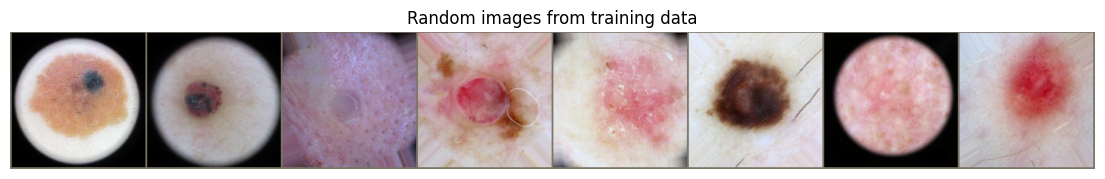

In [ ]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(14, 14))
imshow(out, title='Random images from training data')

# Model: CNN


In [ ]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()        
        
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),           
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
           
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),            
            
        )                  


        self.fc1 = nn.Linear(14 * 14 * 64, 128)    # layer that extract features. لایه ی اضافه شده
        self.fc2 = nn.Linear(128, 2)  
       
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)   
           

        # تبدیل ماتریس ویژگی  به بردار ویژگی
        #out = out.view(out.size(0), -1)  #this converts our 3D feature maps to 1D feature vectors 
        out = out.view(-1, 14 * 14 * 64)
        out =  F.relu(self.fc1(out))
        #out =  self.fc1(out)
        Extract_Feature = out 
        out =  self.fc2(out)
        #out = nn.Softmax(dim=1)(out)
        
        
        return out,Extract_Feature

In [ ]:
model = SimpleCNN()
#  GPU انتقال مدل به
if use_gpu:
    model = model.cuda()
summary(model, (3, 224, 224)) 
model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             224
              ReLU-2          [-1, 8, 224, 224]               0
         MaxPool2d-3          [-1, 8, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]           1,168
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
         MaxPool2d-7           [-1, 16, 56, 56]               0
            Conv2d-8           [-1, 32, 56, 56]           4,640
              ReLU-9           [-1, 32, 56, 56]               0
        MaxPool2d-10           [-1, 32, 28, 28]               0
           Conv2d-11           [-1, 64, 28, 28]          18,496
             ReLU-12           [-1, 64, 28, 28]               0
        MaxPool2d-13           [-1, 64, 14, 14]               0
           Linear-14                  [

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=12544, out_features

## Loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)


In [ ]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)


# Train

In [ ]:
accuracy_total_train = []
accuracy_total_val = []
#Extract_Feature_train = []
#outputs_train = []
def teain_model(model, dataloader):
    num_epochs = 50
    #losses = []

    
    global accuracy_total_train, accuracy_total_val, loss_over_time
    loss_over_time = []
    total = 0
    correct = 0

    for epoch in range(num_epochs):    
        running_loss = 0.0
        for batch_i, data in enumerate(train_dl):
            
            inputs, targets = data 
            inputs = to_var(inputs)
            targets = to_var(targets)
            
        # zero the parameter (weight) gradients
            optimizer.zero_grad()
        
        # forward pass to get outputs
            outputs,Extract_Feature = model(inputs)
            
               
        # calculate the loss
            loss = criterion(outputs, targets)
            #losses += [loss.data.item()]
            running_loss += loss.item()
        # backward pass to calculate the parameter gradients
            loss.backward()
        
        # update the parameters
            optimizer.step()        

        # get the predicted class
            _, predicted = torch.max(outputs.data, 1)
    
        # count up total number of correct labels
            total += targets.size(0)
            correct += (predicted == targets).sum()

        # calculate the accuracy
        # to convert `correct` from a Tensor into a scalar, use .item()
            accuracy = 100.0 * correct.item() / total
            
            

            if dataloader == train_dl:
               #acc_train = accuracy
               accuracy_total_train.append(accuracy)
            else:
               #acc_test = accuracy
               accuracy_total_val.append(accuracy)   




           # print it out!    
            if (batch_i + 1) % 50 == 0:
                avg_loss = running_loss/50
                print('Epoch [%2d/%2d], Step [%3d/%3d], avg_loss: %.4f, Accuracy: %.4f'
                   % (epoch + 1, num_epochs, batch_i + 1, len(train_ds) // batch_size, avg_loss, accuracy))   
                loss_over_time.append(avg_loss)  
                running_loss = 0.0
               

In [ ]:
teain_model(model, train_dl)

Epoch [ 1/50], Step [ 50/ 99], avg_loss: 0.6958, Accuracy: 49.7500
Epoch [ 2/50], Step [ 50/ 99], avg_loss: 0.6941, Accuracy: 50.8230
Epoch [ 3/50], Step [ 50/ 99], avg_loss: 0.6838, Accuracy: 53.5622
Epoch [ 4/50], Step [ 50/ 99], avg_loss: 0.6759, Accuracy: 55.3403
Epoch [ 5/50], Step [ 50/ 99], avg_loss: 0.6814, Accuracy: 55.6176
Epoch [ 6/50], Step [ 50/ 99], avg_loss: 0.6443, Accuracy: 57.0859
Epoch [ 7/50], Step [ 50/ 99], avg_loss: 0.6051, Accuracy: 58.5334
Epoch [ 8/50], Step [ 50/ 99], avg_loss: 0.5917, Accuracy: 59.6276
Epoch [ 9/50], Step [ 50/ 99], avg_loss: 0.5716, Accuracy: 60.8119
Epoch [10/50], Step [ 50/ 99], avg_loss: 0.5831, Accuracy: 61.4095
Epoch [11/50], Step [ 50/ 99], avg_loss: 0.5220, Accuracy: 62.6634
Epoch [12/50], Step [ 50/ 99], avg_loss: 0.5012, Accuracy: 63.7478
Epoch [13/50], Step [ 50/ 99], avg_loss: 0.5144, Accuracy: 64.5099
Epoch [14/50], Step [ 50/ 99], avg_loss: 0.4164, Accuracy: 65.6840
Epoch [15/50], Step [ 50/ 99], avg_loss: 0.3983, Accuracy: 66.

##ِDiagram: Train Accuracy

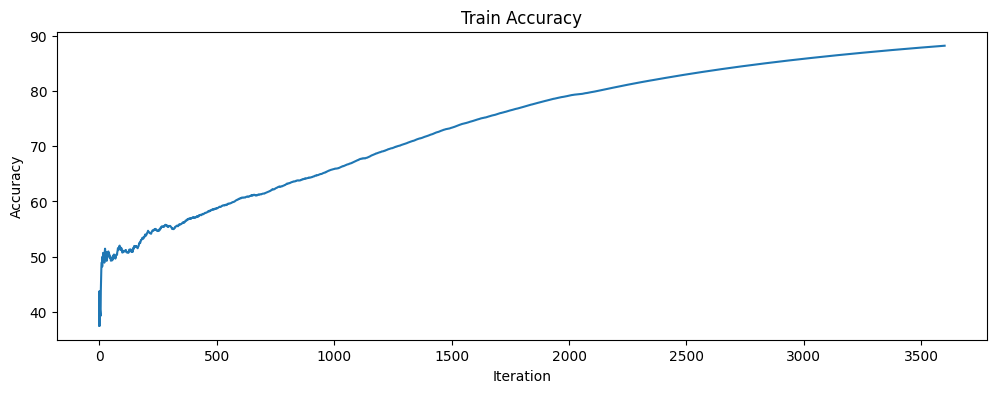

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(accuracy_total_train)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Train Accuracy');

##ِDiagram: Cross Entropy Loss

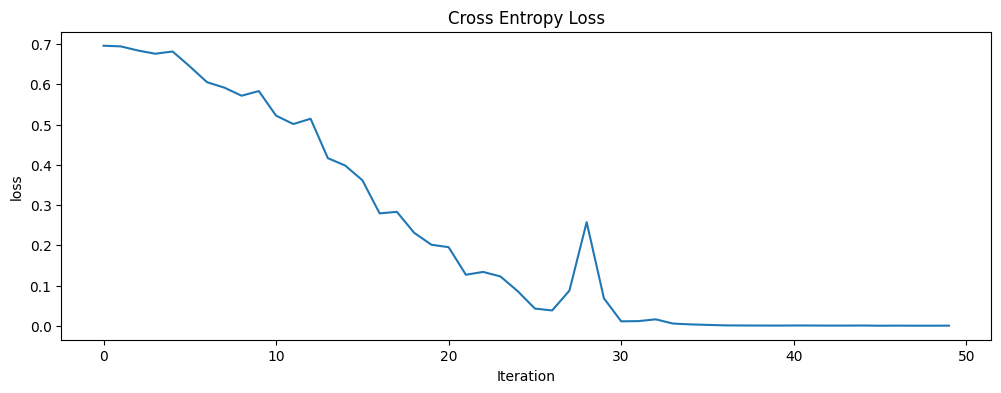

In [ ]:
plt.figure(figsize=(12, 4))
#plt.plot(losses)
plt.plot(loss_over_time)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');

## Accuracy on validation and Test data

In [ ]:
def predict_class(model, dataloader):
    """ Predict probabilities for the given model and dataset
    """
    model.train(False)
    result = []
    y = []
    Extract_Feature_t = []

    for inputs, targets in tqdm(dataloader):
        inputs, targets = to_var(inputs, volatile=True), to_var(targets, volatile=True)

        outputs,Extract_Feature = model(inputs)
        
        
        _, preds = torch.max(outputs.data, 1)
        result += [preds.cpu().numpy()]
        y += [targets.cpu().numpy()]
        
    result = np.concatenate(result)
    y = np.concatenate(y)
    
    return result, y

In [ ]:
y_pred, y_true = predict_class(model, valid_dl)

  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-17-b7aefa0c3230>:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
100%|██████████| 13/13 [00:00<00:00, 16.28it/s]


In [ ]:
_acc = metrics.accuracy_score(y_true,y_pred)
_pr = metrics.precision_score(y_true,y_pred)
_re = metrics.recall_score(y_true,y_pred)
_f = metrics.f1_score(y_true,y_pred)
print('accuracy:', _acc)
print('precision:', _pr)
print('recall:', _re)
print('f1_score:', _f)
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

accuracy: 0.7941176470588235
precision: 0.7884615384615384
recall: 0.803921568627451
f1_score: 0.7961165048543688
Confusion Matrix:
 [[40 11]
 [10 41]]


In [ ]:
y_pred, y_true = predict_class(model, test_dl)

  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-17-b7aefa0c3230>:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
100%|██████████| 15/15 [00:00<00:00, 19.08it/s]


In [ ]:
_acc = metrics.accuracy_score(y_true,y_pred)
_pr = metrics.precision_score(y_true,y_pred)
_re = metrics.recall_score(y_true,y_pred)
_f = metrics.f1_score(y_true,y_pred)
print('accuracy:', _acc)
print('precision:', _pr)
print('recall:', _re)
print('f1_score:', _f)
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

accuracy: 0.8416666666666667
precision: 0.9074074074074074
recall: 0.7777777777777778
f1_score: 0.8376068376068377
Confusion Matrix:
 [[52  5]
 [14 49]]


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, figsize=(8, 8), title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        annot = "%.2f" % cm[i, j] if cm[i, j] > 0 else "" 
        plt.text(j, i, annot, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

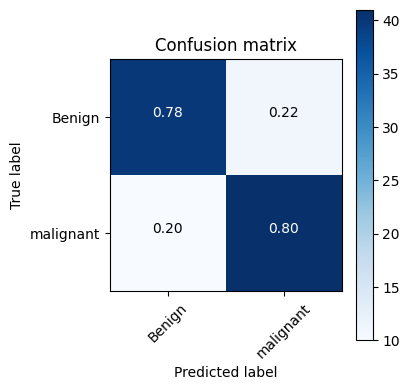

In [ ]:
#y_pred, y_true = predict_class(model, test_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))

#Save Extract Features

In [ ]:
np_features = np.empty([ 674, 128])
np_labels = np.empty([674 , 1])
#batch_size = 8

In [ ]:
z= 0

for batch_i, data in enumerate(train_D):

  inputs, targets = data 
  inputs, targets = inputs.cuda(), targets.cuda()
  inputs, targets = to_var(inputs, True), to_var(targets, True)

  _,Extract_Feature = model(inputs)

  fet = Extract_Feature.cpu().detach().numpy()
  lab = targets.cpu().detach().numpy()
    

  np_features[z] = fet
  np_labels[z] = lab    
  z+=1
  

  


<ipython-input-17-b7aefa0c3230>:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


In [ ]:
# save to npy file

save('/content/drive/MyDrive/ProjectMl/np_features.npy', np_features)
save('/content/drive/MyDrive/ProjectMl/np_labels.npy', np_labels)
np_features = load('/content/drive/MyDrive/ProjectMl/np_features.npy')
np_labels = load('/content/drive/MyDrive/ProjectMl/np_labels.npy')
# print the array
#print(np_labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np_features, np_labels, test_size=0.2, random_state=42)

##Classifier k-Nearest Neighbors (KNN)

In [ ]:

k_range = range(1 , 30)   # range for choose best K

scores = {}
scores_list = []

for k in k_range :
  knn = KNeighborsClassifier(n_neighbors = k)  
  knn.fit(X_train,y_train)
  y_pred = knn.predict(X_test)
  scores[k] = metrics.accuracy_score(y_test,y_pred)
  scores_list.append(metrics.accuracy_score(y_test,y_pred))



/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

In [ ]:
print(scores_list)

[0.9703703703703703, 0.9555555555555556, 0.9703703703703703, 0.9629629629629629, 0.9703703703703703, 0.9703703703703703, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629, 0.9629629629629629]


####The Best k is 2 in range of (1,30)





In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
  # evaluate the performance of the KNN model
print("\KNN Classifier:")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

\KNN Classifier:
Accuracy Score: 0.9629629629629629
Recall: 0.9705882352941176
F1-Score: 0.9635036496350365
Precision: 0.9565217391304348
Confusion Matrix:
 [[64  3]
 [ 2 66]]


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


##Classifier Support Vector Machines (SVC)

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', probability=True)
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)
# evaluate the performance of the SVM model
print("\SVM Classifier:")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

\SVM Classifier:
Accuracy Score: 0.9703703703703703
Recall: 0.9705882352941176
F1-Score: 0.9705882352941176
Precision: 0.9705882352941176
Confusion Matrix:
 [[65  2]
 [ 2 66]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##Classifier Decision Tree (DTC)

In [ ]:
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)
# evaluate the performance of the DTC model
print("\DTC Classifier:")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

\DTC Classifier:
Accuracy Score: 0.9333333333333333
Recall: 0.9264705882352942
F1-Score: 0.9333333333333335
Precision: 0.9402985074626866
Confusion Matrix:
 [[63  4]
 [ 5 63]]


##Classifier RandomForest (RF)

In [ ]:
RF = RandomForestClassifier(n_estimators = 1000)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
# evaluate the performance of the RF model
print("\RF Classifier:")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

<ipython-input-79-34f26b3adc26>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train, y_train)


\RF Classifier:
Accuracy Score: 0.9629629629629629
Recall: 0.9558823529411765
F1-Score: 0.962962962962963
Precision: 0.9701492537313433
Confusion Matrix:
 [[65  2]
 [ 3 65]]


##Classifier Logistic Regression (LR)



In [ ]:
LR = LogisticRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
# evaluate the performance of the LR model
print("\LR Classifier:")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

\LR Classifier:
Accuracy Score: 0.9629629629629629
Recall: 0.9558823529411765
F1-Score: 0.962962962962963
Precision: 0.9701492537313433
Confusion Matrix:
 [[65  2]
 [ 3 65]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##Classifier GaussianNB (GNB)



In [ ]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(X_train, y_train)
y_pred = GNB.predict(X_test)
# evaluate the performance of the GNB model
print("\GNB Classifier:")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

\GNB Classifier:
Accuracy Score: 0.9407407407407408
Recall: 0.9264705882352942
F1-Score: 0.9402985074626866
Precision: 0.9545454545454546
Confusion Matrix:
 [[64  3]
 [ 5 63]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##Classifier  (LDA)



In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
LDA = LDA()
LDA.fit(X_train, y_train)
y_pred = LDA.predict(X_test)
# evaluate the performance of the LDA model
print("\LDA Classifier:")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

\LDA Classifier:
Accuracy Score: 0.9629629629629629
Recall: 0.9558823529411765
F1-Score: 0.962962962962963
Precision: 0.9701492537313433
Confusion Matrix:
 [[65  2]
 [ 3 65]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Voting  Classifier For Ensemble Classification 
###(LR, SVC, DTC, KNN, RF, GNB, LDA)

In [ ]:
# Voting classifier
estimator = [] 
estimator.append(('LR',  
                  LogisticRegression(solver ='lbfgs',  
                                     multi_class ='multinomial',  
                                     max_iter = 200))) 


estimator.append(('KNN', KNeighborsClassifier(n_neighbors=2)))

estimator.append(('GNB', GaussianNB()))
#estimator.append(('LDA',LDA()))

vot_hard = VotingClassifier(estimators = estimator, voting ='hard') 
vot_hard.fit(X_train, y_train) 
y_pred = vot_hard.predict(X_test)   # predict X_test labels
print("\Voting classifier:")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

\Voting classifier:
Accuracy Score: 0.9703703703703703
Recall: 0.9558823529411765
F1-Score: 0.9701492537313432
Precision: 0.9848484848484849
Confusion Matrix:
 [[66  1]
 [ 3 65]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
# Voting classifier
estimator = [] 
estimator.append(('LR',  
                  LogisticRegression(solver ='lbfgs',  
                                     multi_class ='multinomial',  
                                     max_iter = 200))) 
estimator.append(('SVC', SVC(kernel='linear', probability = True))) 
estimator.append(('DTC', DecisionTreeClassifier()))


vot_hard = VotingClassifier(estimators = estimator, voting ='hard') 
vot_hard.fit(X_train, y_train) 
y_pred = vot_hard.predict(X_test)   # predict X_test labels
print("\Voting classifier:")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

\Voting classifier:
Accuracy Score: 0.9629629629629629
Recall: 0.9558823529411765
F1-Score: 0.962962962962963
Precision: 0.9701492537313433
Confusion Matrix:
 [[65  2]
 [ 3 65]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
# Voting classifier
estimator = [] 
estimator.append(('LR',  
                  LogisticRegression(solver ='lbfgs',  
                                     multi_class ='multinomial',  
                                     max_iter = 200))) 
estimator.append(('SVC', SVC(kernel='linear', probability = True))) 
estimator.append(('DTC', DecisionTreeClassifier()))
estimator.append(('KNN', KNeighborsClassifier(n_neighbors=2)))
#estimator.append(('RF', RandomForestClassifier(n_estimators = 1000)))
estimator.append(('GNB', GaussianNB()))
estimator.append(('LDA',LDA()))

vot_hard = VotingClassifier(estimators = estimator, voting ='hard') 
vot_hard.fit(X_train, y_train) 
y_pred = vot_hard.predict(X_test)   # predict X_test labels
print("\Voting classifier:")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


\Voting classifier:
Accuracy Score: 0.9703703703703703
Recall: 0.9558823529411765
F1-Score: 0.9701492537313432
Precision: 0.9848484848484849
Confusion Matrix:
 [[66  1]
 [ 3 65]]


##Confusion Matrix

In [ ]:
train_ds = datasets.ImageFolder(trn_dir)
train_ds.classes
train_ds.class_to_idx

{'Benign': 0, 'malignant': 1}

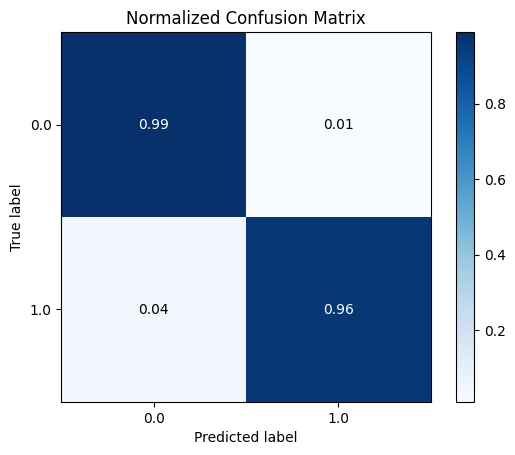

In [ ]:
from sklearn.model_selection import cross_val_predict
class_names = ['Benign', 'malignant']
y_pred= vot_hard.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

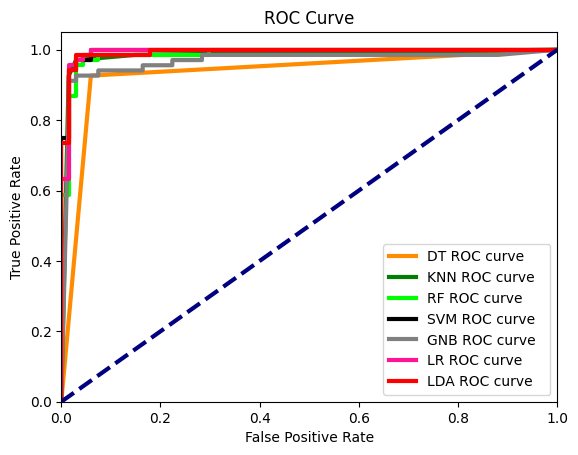

In [ ]:
from sklearn.metrics import roc_curve

y_pred_probDT = DT.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_probDT)

roc_auc = auc(fpr, tpr)

y_pred_probKNN = knn.predict_proba(X_test)[:,1]
fpr1, tpr1, threshold = roc_curve(y_test, y_pred_probKNN)

roc_auc1 = auc(fpr1, tpr1)

y_pred_probRF = RF.predict_proba(X_test)[:,1]
fpr2, tpr2, threshold = roc_curve(y_test, y_pred_probRF)

roc_auc2 = auc(fpr2, tpr2)

y_pred_probsvm = svclassifier.predict_proba(X_test )[:,1]
fpr3, tpr3, threshold = roc_curve(y_test, y_pred_probsvm)

roc_auc3 = auc(fpr3, tpr3)

y_pred_probGNB = GNB.predict_proba(X_test)[:,1]
fpr4, tpr4, threshold = roc_curve(y_test, y_pred_probGNB)

roc_auc4 = auc(fpr4, tpr4)

y_pred_probLR = LR.predict_proba(X_test)[:,1]
fpr5, tpr5, threshold = roc_curve(y_test, y_pred_probLR)

roc_auc5 = auc(fpr5, tpr5)

y_pred_probLDA = LDA.predict_proba(X_test)[:,1]
fpr6, tpr6, threshold = roc_curve(y_test, y_pred_probLDA)

roc_auc6 = auc(fpr6, tpr6)

lw = 3
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='DT ROC curve')
plt.plot(fpr1, tpr1, color='green', lw=3, label='KNN ROC curve  ')
plt.plot(fpr2, tpr2, color='lime', lw=3, label='RF ROC curve  ')
plt.plot(fpr3, tpr3, color='black', lw=3, label='SVM ROC curve  ')
plt.plot(fpr4, tpr4, color='gray', lw=3, label='GNB ROC curve  ')
plt.plot(fpr5, tpr5, color='deeppink', lw=3, label='LR ROC curve  ')
plt.plot(fpr6, tpr6, color='red', lw=3, label='LDA ROC curve  ')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")